# **Heart Disease Prediction**

## **Model Selection and Optimization**  
This notebook focuses on the process of **selecting and optimizing the best machine learning model** for predicting heart disease. The goal is to identify a model that outperforms the baseline while ensuring robustness and generalization.

The models at least has to be better than the baseline model (heuristic approach). Modelo Base

All steps will be implemented using **scikit-learn** and other relevant libraries to ensure a structured and reproducible workflow.  

`Simón Correa Marín`


### **1. Import Libraries and Configurations**

In [2]:
# base libraries for data science
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import (
    KFold,
    ShuffleSplit,
    cross_val_score,
    learning_curve,
    train_test_split,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder


### **2. Load Data**

In [3]:
DATA_DIR = Path.cwd().resolve().parents[0] / "data"

hd_df = pd.read_parquet(
    DATA_DIR / "02_intermediate/hd_type_fixed.parquet", engine="pyarrow"
)

In [4]:
# print library version for reproducibility

print("Pandas version: ", pd.__version__)

Pandas version:  2.2.3


### **3. Data Preparation**

In [5]:
hd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6848 entries, 0 to 6847
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   rest_ecg    6392 non-null   category
 1   ca          6479 non-null   float64 
 2   thal        6552 non-null   category
 3   max_hr      6453 non-null   float64 
 4   exang       6848 non-null   bool    
 5   old_peak    6493 non-null   float64 
 6   chol        6643 non-null   float64 
 7   rest_bp     6655 non-null   float64 
 8   chest_pain  6648 non-null   category
 9   disease     6848 non-null   bool    
 10  sex         6692 non-null   category
 11  fbs         6848 non-null   bool    
 12  slope       6492 non-null   float64 
 13  age         6763 non-null   float64 
dtypes: bool(3), category(4), float64(7)
memory usage: 422.0 KB


#### **Missing Values**

In [6]:
hd_df.isna().sum()

rest_ecg      456
ca            369
thal          296
max_hr        395
exang           0
old_peak      355
chol          205
rest_bp       193
chest_pain    200
disease         0
sex           156
fbs             0
slope         356
age            85
dtype: int64

#### **Duplicated Data**

In [7]:
duplicate_rows = hd_df.duplicated().sum()
print("Number of duplicate rows: ", duplicate_rows)

Number of duplicate rows:  6340


In [8]:
hd_df = hd_df.drop_duplicates()
hd_df.shape

(508, 14)

There are 508 rows left after deleting duplicated rows

In [9]:
# Missing values after dropping duplicates
hd_df.isna().sum()

rest_ecg      143
ca             89
thal           74
max_hr        121
exang           0
old_peak      107
chol           60
rest_bp        56
chest_pain     58
disease         0
sex            43
fbs             0
slope         107
age            17
dtype: int64

In [10]:
# Encode target variable
hd_df["disease"] = hd_df["disease"].astype("int64")
# True = 1, False = 0

In [11]:
hd_df.sample(10)

,rest_ecg,ca,thal,max_hr,exang,old_peak,chol,rest_bp,chest_pain,disease,sex,fbs,slope,age
784,NaN,NaN,NaN,NaN,True,NaN,250.0,112.0,nonanginal,1,Male,False,NaN,41.0
296,normal,0.0,normal,114.0,False,2.6,226.0,150.0,typical,0,Female,False,3.0,66.0
228,left ventricular hypertrophy,0.0,normal,152.0,False,1.2,197.0,130.0,nonanginal,0,NaN,True,3.0,NaN
205,normal,1.0,reversable,156.0,False,0.1,234.0,100.0,asymptomatic,1,Male,False,1.0,58.0
320,left ventricular hypertrophy,1.0,reversable,103.0,False,1.4,281.0,120.0,nontypical,1,Male,False,2.0,62.0
704,left ventricular hypertrophy,0.0,normal,182.0,False,0.0,321.0,140.0,nonanginal,0,Male,False,1.0,39.0
386,normal,0.0,normal,139.0,False,0.2,275.0,130.0,nonanginal,0,Female,False,1.0,48.0
1002,left ventricular hypertrophy,0.0,normal,151.0,False,0.4,302.0,120.0,asymptomatic,0,Male,False,2.0,66.0
659,left ventricular hypertrophy,0.0,reversable,111.0,True,0.8,270.0,150.0,asymptomatic,1,Male,False,1.0,58.0
71,normal,1.0,reversable,151.0,False,1.0,277.0,118.0,nonanginal,0,Male,False,1.0,68.0


### **3. Feature Engineering**

In [12]:
nom_categorical_cols = ["chest_pain", "rest_ecg", "thal", "sex"]
ord_categorical_cols = ["ca", "slope"]
disc_numerical_cols = ["age", "max_hr", "chol", "rest_bp"]
cont_numerical_cols = ["old_peak"]
boolean_cols = ["exang", "fbs"]

#### **Pipeline**

In [13]:
from sklearn.preprocessing import FunctionTransformer

numeric_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
    ]
)

nom_categorical_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(drop="if_binary")),
    ]
)

ord_categorical_ord_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OrdinalEncoder()),
    ]
)

boolean_pipe = Pipeline(
    steps=[
        ("to_int", FunctionTransformer(lambda x: x.astype("int64"), feature_names_out="one-to-one")),
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(drop="if_binary")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_pipe, disc_numerical_cols+cont_numerical_cols),
        ("nominal_categoric", nom_categorical_pipe, nom_categorical_cols),
        ("ordinal_categoric", ord_categorical_ord_pipe, ord_categorical_cols),
        ("boolean", boolean_pipe, boolean_cols),
    ]
)


In [14]:
preprocessor

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 ['age', 'max_hr', 'chol', 'rest_bp',
                                  'old_peak']),
                                ('nominal_categoric',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(drop='if_binary'))]),
                                 ['chest_pain', 'rest_ecg', 'thal', 'sex']),
                                ('ordinal_categoric',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot', OrdinalEncoder())]),
                                 ['ca', 'slope']),
                                ('boolean',
                                 Pipeline(steps=[('to_int',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function <lambda> at 0x105f29da0>)),
                                                 ('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(drop='if_binary'))]),
                                 ['exang', 'fbs'])])

#### **Train/Test split**

In [15]:
X_features = hd_df.drop("disease", axis="columns")
Y_target = hd_df["disease"]

# 80% train, 20% test
x_train, x_test, y_train, y_test = train_test_split(
    X_features, Y_target, test_size=0.2, stratify=Y_target
)

In [16]:
x_train.shape, y_train.shape

((406, 13), (406,))

In [17]:
x_test.shape, y_test.shape

((102, 13), (102,))

In [18]:
print(x_train.dtypes)

rest_ecg      category
ca             float64
thal          category
max_hr         float64
exang             bool
old_peak       float64
chol           float64
rest_bp        float64
chest_pain    category
sex           category
fbs               bool
slope          float64
age            float64
dtype: object


### **4. Models**

Best Practices is to import the libraries at the beginning of the notebook, but for this notebook, the libraries are imported in the cell where they are used.

In this experiments Basic Machine Learning models are used, and the models are:

- Logistic Regression
- Linear Discriminant Analysis
- Stochastic Gradient Descent classifier
- Linear Support Vector Machine
- Radius Neighbors Classifier
- Gaussian Naive Bayes
- Decision Tree
- Random Forest

In [19]:
# Model libraries
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

#### **Basic Model Selection**
The models are trained with the default hyperparameters, and the models with the best performance will be selected to be tuned in the next step.

#### **Helping functions**

In [20]:
def summarize_classification(y_test, y_pred):
    acc = accuracy_score(y_test, y_pred, normalize=True)
    prec = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_pred)

    return {"accuracy": acc, "precision": prec, "recall": recall, "f1": f1, "roc": roc}

In [21]:
def build_model(
    classifier_fn,
    preprocessor: ColumnTransformer,
    data_params: dict,
    test_frac: float = 0.2,
) -> dict:
    """
    Function to train a classification model

    Args:
        classifier_fn: classification function
        preprocessor (ColumnTransformer): preprocessor pipeline object
        data_params (dict): dictionary containing 'name_of_y_col',
                            'names_of_x_cols', and 'dataset'
        test_frac (float): fraction of data for the test, default 0.2

    Returns:
        dict: dictionary with the model performance metrics on train and test

    """

    # Extract data parameters
    name_of_y_col = data_params["name_of_y_col"]
    names_of_x_cols = data_params["names_of_x_cols"]
    dataset = data_params["dataset"]

    # Separate the feature columns and the target column
    X = dataset[names_of_x_cols]
    Y = dataset[name_of_y_col]

    # Split the data into train and test
    x_train, x_test, y_train, y_test = train_test_split(
        X, Y, test_size=test_frac, random_state=1234
    )

    # Create the pipeline with preprocessing and the classification model
    classifier_pipe = Pipeline(
        steps=[("preprocessor", preprocessor), ("model", classifier_fn)]
    )

    # Train the classifier pipeline
    model = classifier_pipe.fit(x_train, y_train)

    # Predict the test data
    y_pred = model.predict(x_test)

    # Predict the train data
    y_pred_train = model.predict(x_train)

    # Calculate the performance metrics
    train_summary = summarize_classification(y_train, y_pred_train)
    test_summary = summarize_classification(y_test, y_pred)

    return {"train": train_summary, "test": test_summary}

#### **First Selection of Models**

The idea is to do a simple train an evaluate the models to see which ones are the worst to discard them.

In [22]:
FEATURES = list(x_train.columns)
FEATURES

['rest_ecg',
 'ca',
 'thal',
 'max_hr',
 'exang',
 'old_peak',
 'chol',
 'rest_bp',
 'chest_pain',
 'sex',
 'fbs',
 'slope',
 'age']

#### **Simple Training and Evaluation**

In [23]:
result_dict = {}
models = {
    "logistic": LogisticRegression(solver="liblinear"),
    "lda": LinearDiscriminantAnalysis(),
    "sgd": SGDClassifier(),
    "svc": LinearSVC(C=1.0, max_iter=1000, tol=1e-3, dual=False),
    "radius_neighbors": RadiusNeighborsClassifier(radius=40.0),
    "naive_bayes": GaussianNB(),
    "decision_tree": DecisionTreeClassifier(),
    "random_forest": RandomForestClassifier(),
}

data_params = {
    "name_of_y_col": "disease",
    "names_of_x_cols": FEATURES,
    "dataset": hd_df,
}
for model_name, model in models.items():
    result_dict[model_name] = build_model(model, preprocessor, data_params)

#### **Model Comparison**

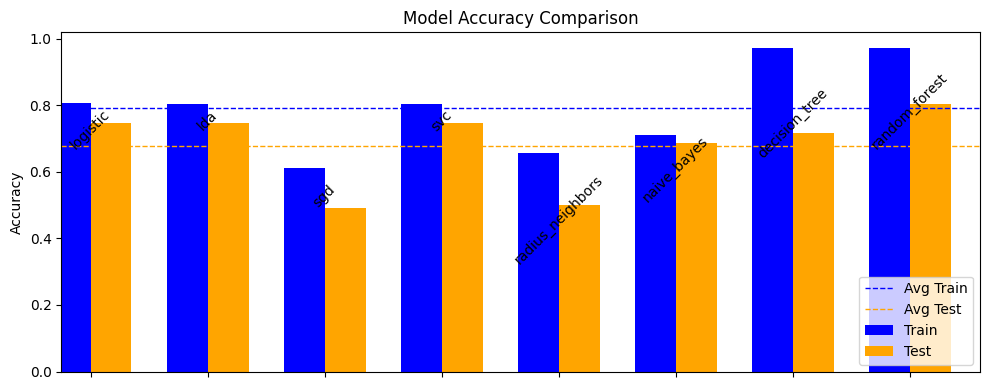

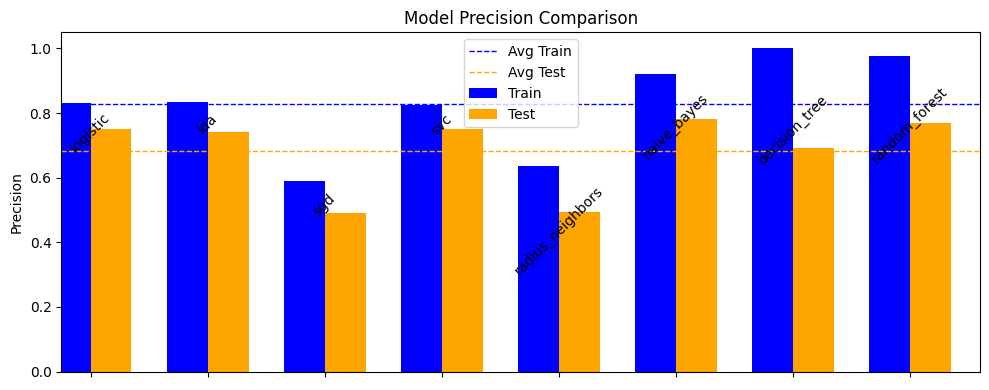

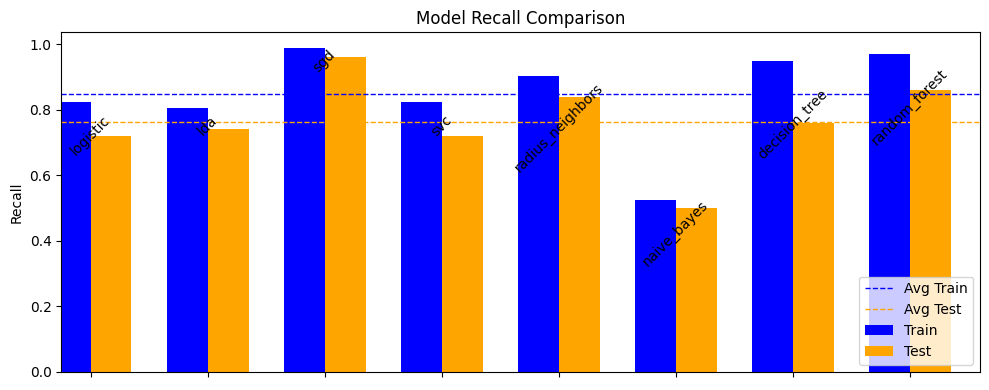

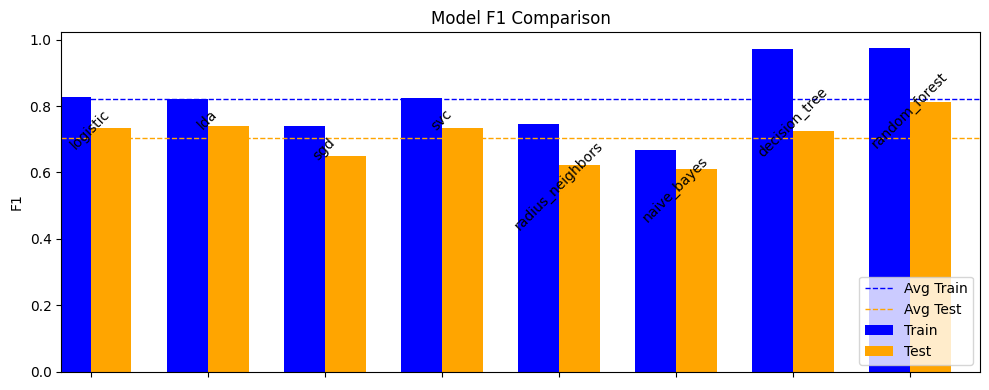

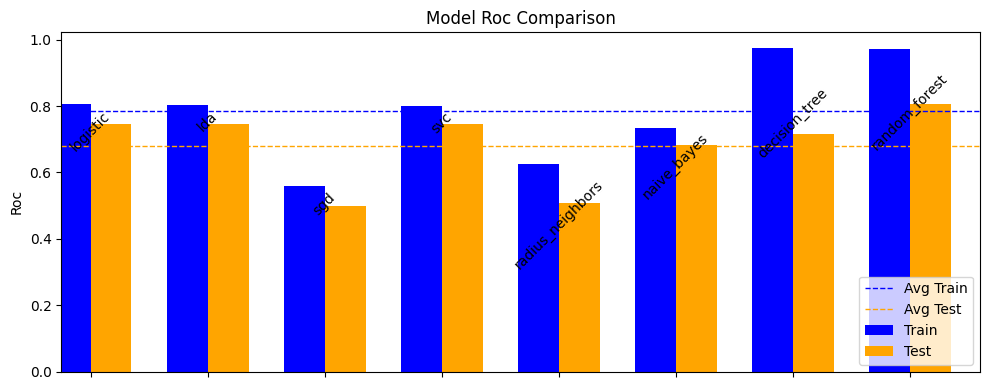

In [24]:
# Convert the result_dict to a DataFrame for easier plotting
metrics = ["accuracy", "precision", "recall", "f1", "roc"]
models = list(result_dict.keys())
data_train = {
    metric: {model: result_dict[model]["train"][metric] for model in models}
    for metric in metrics
}
data_test = {
    metric: {model: result_dict[model]["test"][metric] for model in models}
    for metric in metrics
}

df_train = pd.DataFrame(data_train)
df_test = pd.DataFrame(data_test)

# Plot the bar chart for each metric
for metric in metrics:
    fig, ax = plt.subplots(figsize=(10, 4))
    width = 0.35  # the width of the bars

    df_train[metric].plot(
        kind="bar", ax=ax, width=width, position=1, label="Train", color="blue"
    )
    df_test[metric].plot(
        kind="bar", ax=ax, width=width, position=0, label="Test", color="orange"
    )

    # Add horizontal lines for average performance
    avg_train = df_train[metric].mean()
    avg_test = df_test[metric].mean()
    ax.axhline(avg_train, color="blue", linestyle="--", linewidth=1, label="Avg Train")
    ax.axhline(avg_test, color="orange", linestyle="--", linewidth=1, label="Avg Test")

    # Adjust the layout
    ax.set_ylabel(metric.capitalize())
    ax.set_title(f"Model {metric.capitalize()} Comparison")
    ax.legend()

    # Set the x-tick labels inside the bars and rotate by 90 degrees
    ax.set_xticks(range(len(df_train.index)))
    ax.set_xticklabels([])

    # Draw the x-tick labels inside the bars rotated by 90 degrees
    for i, label in enumerate(df_train.index):
        bar_center = (df_train.loc[label, metric] + df_test.loc[label, metric]) / 2
        ax.text(i, bar_center, label, ha="center", va="center_baseline", rotation=45)

    plt.tight_layout()
    plt.show()

In [25]:
# Create a DataFrame combining df_train and df_test
df_combined = pd.concat(
    [df_train.add_suffix("_train"), df_test.add_suffix("_test")], axis=1
)

# Calculate the difference between train and test values
df_combined["accuracy_diff"] = (
    df_combined["accuracy_train"] - df_combined["accuracy_test"]
)
df_combined["precision_diff"] = (
    df_combined["precision_train"] - df_combined["precision_test"]
)
df_combined["recall_diff"] = df_combined["recall_train"] - df_combined["recall_test"]
df_combined["f1_diff"] = df_combined["f1_train"] - df_combined["f1_test"]
df_combined["roc_diff"] = df_combined["roc_train"] - df_combined["roc_test"]

# Detect models with overfitting (significant difference between train and test)
overfitting_threshold = 0.1  # Threshold to consider overfitting
overfitting_models = df_combined[
    (df_combined["accuracy_diff"] > overfitting_threshold)
    | (df_combined["precision_diff"] > overfitting_threshold)
    | (df_combined["recall_diff"] > overfitting_threshold)
    | (df_combined["f1_diff"] > overfitting_threshold)
    | (df_combined["roc_diff"] > overfitting_threshold)
]

# Calculate the average performance in train and test for each metric
mean_performance_train = df_combined[
    ["accuracy_train", "precision_train", "recall_train", "f1_train", "roc_train"]
].mean()
mean_performance_test = df_combined[
    ["accuracy_test", "precision_test", "recall_test", "f1_test", "roc_test"]
].mean()

# Detect models with low performance
# (performance in both train and test below the average of other models)
low_performance_models = df_combined[
    (df_combined["accuracy_train"] < mean_performance_train["accuracy_train"])
    & (df_combined["accuracy_test"] < mean_performance_test["accuracy_test"])
    & (df_combined["precision_train"] < mean_performance_train["precision_train"])
    & (df_combined["precision_test"] < mean_performance_test["precision_test"])
    & (df_combined["recall_train"] < mean_performance_train["recall_train"])
    & (df_combined["recall_test"] < mean_performance_test["recall_test"])
    & (df_combined["f1_train"] < mean_performance_train["f1_train"])
    & (df_combined["f1_test"] < mean_performance_test["f1_test"])
    & (df_combined["roc_train"] < mean_performance_train["roc_train"])
    & (df_combined["roc_test"] < mean_performance_test["roc_test"])
]

print(f"Models with overfitting: {list(overfitting_models.index)} ")
print(f"Models with low performance: {list(low_performance_models.index)} ")

Models with overfitting: ['logistic', 'sgd', 'svc', 'radius_neighbors', 'naive_bayes', 'decision_tree', 'random_forest'] 
Models with low performance: [] 


In [26]:
# Detect models with similar performance in train and test
similar_performance_threshold = 0.05  # Threshold to consider similar performance
similar_performance_models = df_combined[
    (df_combined["accuracy_diff"].abs() < similar_performance_threshold)
    & (df_combined["precision_diff"].abs() < similar_performance_threshold)
    & (df_combined["recall_diff"].abs() < similar_performance_threshold)
    & (df_combined["f1_diff"].abs() < similar_performance_threshold)
    & (df_combined["roc_diff"].abs() < similar_performance_threshold)
]

print(
    "Models with similar performance in train and test: "
    f"{list(similar_performance_models.index)}"
)

Models with similar performance in train and test: []


In [27]:
overfitting_models

,accuracy_train,precision_train,recall_train,f1_train,roc_train,accuracy_test,precision_test,recall_test,f1_test,roc_test,accuracy_diff,precision_diff,recall_diff,f1_diff,roc_diff
logistic,0.807882,0.831111,0.823789,0.827434,0.805749,0.745098,0.750000,0.72,0.734694,0.744615,0.062784,0.081111,0.103789,0.092740,0.061134
sgd,0.610837,0.591029,0.986784,0.739274,0.560431,0.490196,0.489796,0.96,0.648649,0.499231,0.120641,0.101233,0.026784,0.090625,0.061200
svc,0.802956,0.823789,0.823789,0.823789,0.800162,0.745098,0.750000,0.72,0.734694,0.744615,0.057858,0.073789,0.103789,0.089095,0.055547
radius_neighbors,0.657635,0.636646,0.903084,0.746812,0.624726,0.500000,0.494118,0.84,0.622222,0.506538,0.157635,0.142528,0.063084,0.124590,0.118188
naive_bayes,0.709360,0.922481,0.524229,0.668539,0.734182,0.686275,0.781250,0.50,0.609756,0.682692,0.023085,0.141231,0.024229,0.058783,0.051489
decision_tree,0.970443,1.000000,0.947137,0.972851,0.973568,0.715686,0.690909,0.76,0.723810,0.716538,0.254757,0.309091,0.187137,0.249041,0.257030
random_forest,0.970443,0.977778,0.969163,0.973451,0.970615,0.803922,0.767857,0.86,0.811321,0.805000,0.166522,0.209921,0.109163,0.162131,0.165615


In [28]:
low_performance_models

,accuracy_train,precision_train,recall_train,f1_train,roc_train,accuracy_test,precision_test,recall_test,f1_test,roc_test,accuracy_diff,precision_diff,recall_diff,f1_diff,roc_diff


In [29]:
similar_performance_models

,accuracy_train,precision_train,recall_train,f1_train,roc_train,accuracy_test,precision_test,recall_test,f1_test,roc_test,accuracy_diff,precision_diff,recall_diff,f1_diff,roc_diff
